# Lineare Diskriminanzanalyse
## Araz, Hasenklever, Pede

Laden von Bibliotheken

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import random
import scipy

from scipy.stats import zscore

# interactive
from ipywidgets.widgets import interact, IntSlider, FloatSlider
from IPython.display import display


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from multiDatenanalyse import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mmPfad = r"D:\C\Uni\Master\KSS\MV_Analyse\Messmatrix.csv"#'../data/Messmatrix.csv'

## Laden der Merkmalsmatrix
### und Vorverarbeitung von Zeilen und Spalten nach Anzahl von NaNs und stark korrelierenden Merkmalen

In [3]:
df = load_data(mmPfad)

Rohe Daten: 

Anzahl der Kennwerte: 88
Anzahl der vermessenen Rohre: 220995
Anzahl der gefahrenen Produkte: 27
Anzahl der Walzlose: 1435

Daten nach Vorverarbeitung: 

Anzahl der Kennwerte: 53
Anzahl der vermessenen Rohre: 165902
Anzahl der gefahrenen Produkte: 27
Anzahl der Walzlose: 1143

Korrelierte Merkmale entfernen

WAS_Blockmasse  und  WAS_Blocklaenge korrelieren positiv
WAS_Blockmasse  und  SWW_Huellenlaenge korrelieren positiv
WAS_Blockmasse  und  LOP_Stoesselweg korrelieren positiv
WAS_Blocklaenge  und  SWW_Huellenlaenge korrelieren positiv
WAS_Blocklaenge  und  LOP_Stoesselweg korrelieren positiv
Zaehler_Dorn_links  und  Zaehler_Dorn_rechts korrelieren positiv
SWW_Huellenlaenge  und  LOP_Stoesselweg korrelieren positiv
SRW_WD_erste_Toleranzunterschreitung  und  SRW_WD_Laenge_Enden korrelieren positiv
SRW_WD_erste_Toleranzunterschreitung  und  SRW_WD_Anteil_Enden korrelieren positiv
SRW_WD_Laenge_Enden  und  SRW_WD_Anteil_Enden korrelieren positiv
SRW_WD_Abweichung_Soll  und 

## Produktweise Sortierung der Daten

minimale Anzahl der Rohre je Walzlos festlegen, um die Schätzung je Walzlos zu verbessern,
und Daten nach Produkten sortieren

In [5]:
min_num_walzlos = 300
df_all_prod = [extract_product(df, product_id=product_id, min_num_walzlos=min_num_walzlos) for product_id in range(26)]

Auswahl des Produtes durch Schieberegler implementieren

TODO Produkteigenschaften (LG, AD, WD) ausgeben

In [7]:
@interact(index=IntSlider(min=0, max=25, value = 11))
def count_per_product(index):
    print("Anzahl der Walzlose: "+str(len(pd.unique(df_all_prod[index]["Header_Walzlos"]))))

Anzahl der Walzlose: 10


Auswahl eines Produktes und Ausgabe der Anzahl von Walzlosen mit "genügend" Rohren

In [8]:
product_id = 11
df_prod = df_all_prod[product_id]
print("Anzahl der Walzlose: "+str(len(pd.unique(df_prod["Header_Walzlos"]))))

Anzahl der Walzlose: 10


Verbleibende Merkmale:

In [9]:
df_prod.columns

Index(['Header_Pseudonummer', 'Header_Walzlos', 'Header_Leitguete',
       'Header_Anzahl_Bloecke_im_Los', 'Header_Soll_AD', 'Header_Soll_WD',
       'WAS_Blockmasse', 'WAS_Kerntemperatur', 'WAS_Oberflaechentemperatur',
       'DHO_Entkohlung', 'DHO_Kerntemperatur_z4', 'DHO_Verweilzeit_ges',
       'DHO_Zunderverlust_per', 'DHO_Liegepos_Reihe', 'DHO_Liegepos_Pos',
       'DHO_Ziehtakt', 'Zaehler_Dorn_links', 'DST_Temp_vor_KG_1',
       'DST_Temp_nach_KG_2', 'SWW_Durchm_Streckerhuelle', 'LOP_Umformarbeit',
       'LOP_Presskraft_Mittelwert', 'LOP_std_dev', 'LOP_Kruemmung',
       'LOP_Geschw', 'STB_Huellentemp_Mittelwert', 'SPL_T_vor_SPL_Mittelwert',
       'SPL_T_vor_SPL_Standardabweichung', 'SPL_T_vor_SPL_Kruemmung',
       'SRW_WD_erste_Toleranzunterschreitung',
       'SRW_WD_letzte_Toleranzunterschreitung', 'SRW_WD_Mittelwert',
       'SRW_WD_Standardabweichung', 'SRW_WD_Trend',
       'SRW_WD_Flaeche_Mitte_ausser_Toleranz', 'SRW_WD_Abweichung_Soll',
       'SPL_Luppentemp_nach_SPL

## Aufteilen der Daten in Test- und Trainingsdaten

In [10]:
test_frac = 0.2
train_set, test_set = get_lda_data(df_prod, test_frac=test_frac)

## Normalisierung der Daten

In [11]:
train_set['data'] = zscore(train_set['data'])
test_set['data'] = zscore(test_set['data'])

## Kovarianzmatrix von Trainings- und Testdaten

Wie selbstähnlich sind die Test- und Trainingsdaten?


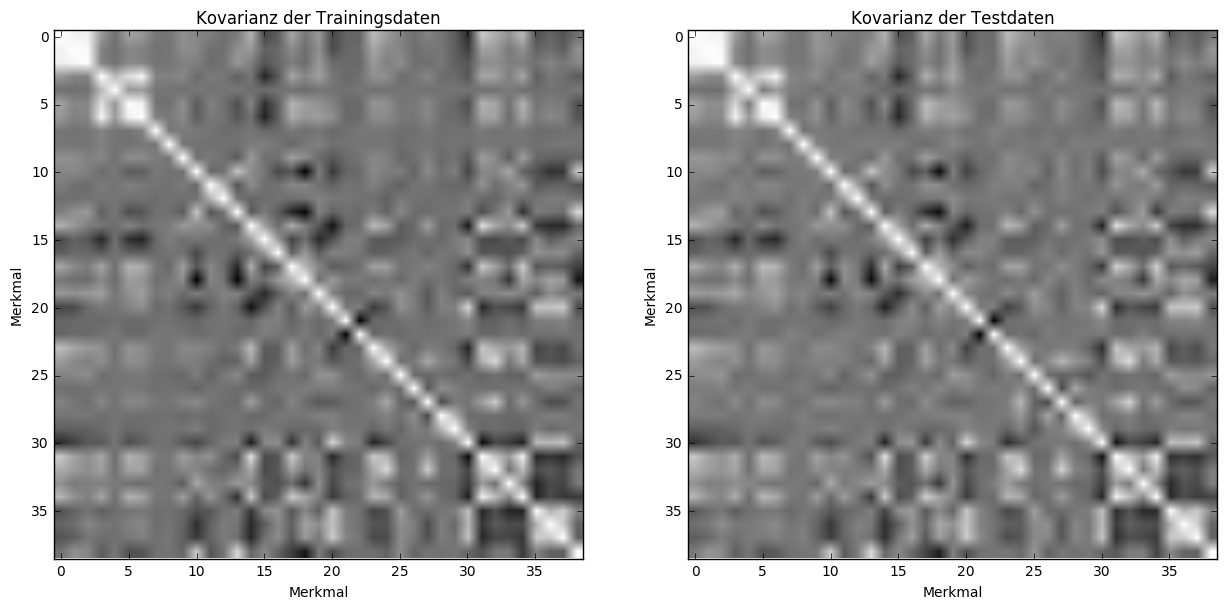

In [12]:
cov_train = np.cov(train_set['data'].T)
cov_test = np.cov(test_set['data'].T)

plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
ax1.imshow(255*(cov_train-np.max(cov_train))/(np.max(cov_train)-np.min(cov_train)), 'gray')
ax1.set_title('Kovarianz der Trainingsdaten')
ax1.set_xlabel('Merkmal')
ax1.set_ylabel('Merkmal')

ax2 = plt.subplot(122)
ax2.imshow(255*(cov_test-np.max(cov_test))/(np.max(cov_test)-np.min(cov_test)), 'gray')
ax2.set_title('Kovarianz der Testdaten')
ax2.set_xlabel('Merkmal')
ax2.set_ylabel('Merkmal')
print('Wie selbstähnlich sind die Test- und Trainingsdaten?')

## Dürchführen der LDA auf die Trainingsdaten

In [13]:
# extract data and label
X_train, y_train = train_set['data'], train_set['label']
X_test, y_test = test_set['data'], test_set['label']

# number components for transform
n_components = 3

# LDA object
sklearn_LDA = LDA(n_components=n_components, solver='eigen')

# fit with train data
sklearn_LDA = sklearn_LDA.fit(X_train, y_train)

## Darstellung der Eigenwerte

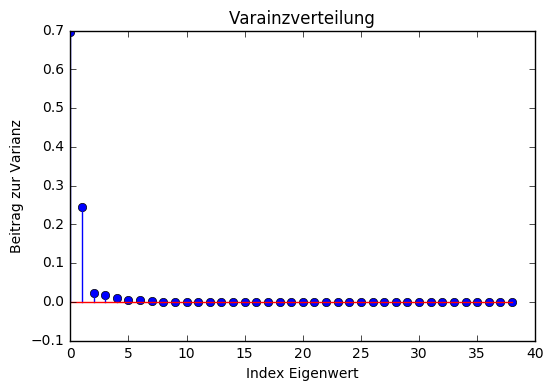

In [15]:
plt.stem(sklearn_LDA.explained_variance_ratio_)
plt.xlabel('Index Eigenwert')
plt.ylabel('Beitrag zur Varianz')
plt.title("Varainzverteilung")

## Testen der Klassifikation

In [16]:
train_pred = sklearn_LDA.predict(X_train)
print('{0:.2f}% Genauigkeit bei der Klassifikation der Trainingsdaten'.format(100*np.mean(train_pred == y_train)))

test_pred = sklearn_LDA.predict(X_test)
print('{0:.2f}% Genauigkeit bei der Klassifikation der Testdaten'.format(100*np.mean(test_pred == y_test)))

98.56% Genauigkeit bei der Klassifikation der Trainingsdaten
98.06% Genauigkeit bei der Klassifikation der Testdaten


## Darstellung der transformierten Trainingsdaten und Klassenzugehörigkeit

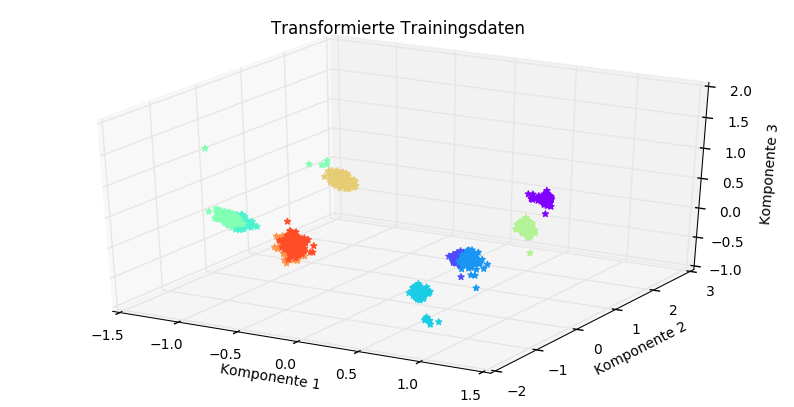

In [17]:
data = sklearn_LDA.transform(X_train)
plot_lda(data, y_train, 'Transformierte Trainingsdaten')

## Interpretation der LDA-Ergebnisse

### Die Helligkeit der Punkte bildet die Größe des Beitrags des Merkmals im jeweiligen Eigenvektor ab. 

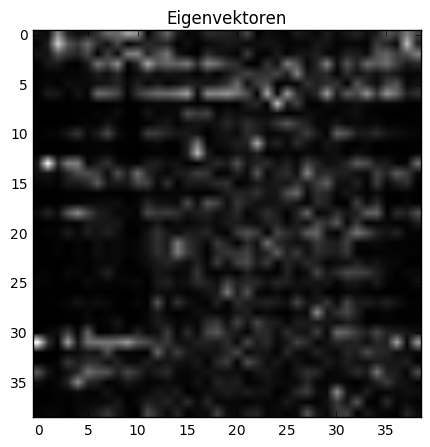

In [18]:
eigvecs = sklearn_LDA.scalings_
plt.figure(figsize=(20,5))
plt.imshow(np.abs(eigvecs), 'gray')
#_ = plt.axis('off')
plt.title("Eigenvektoren")

In [19]:
print('Einflussreichstes Merkmal im ersten EV: {}'.format(df[df.columns[6:]].columns[np.argmax(np.abs(eigvecs[:, 0]))]))
print('Einflussreichstes Merkmal im zweiten EV: {}'.format(df[df.columns[6:]].columns[np.argmax(np.abs(eigvecs[:, 1]))]))

Einflussreichstes Merkmal im ersten EV: SRW_Geschw_2_Mittelwert
Einflussreichstes Merkmal im zweiten EV: SWW_Durchm_Streckerhuelle


## Darstellung der Eigenvektoren

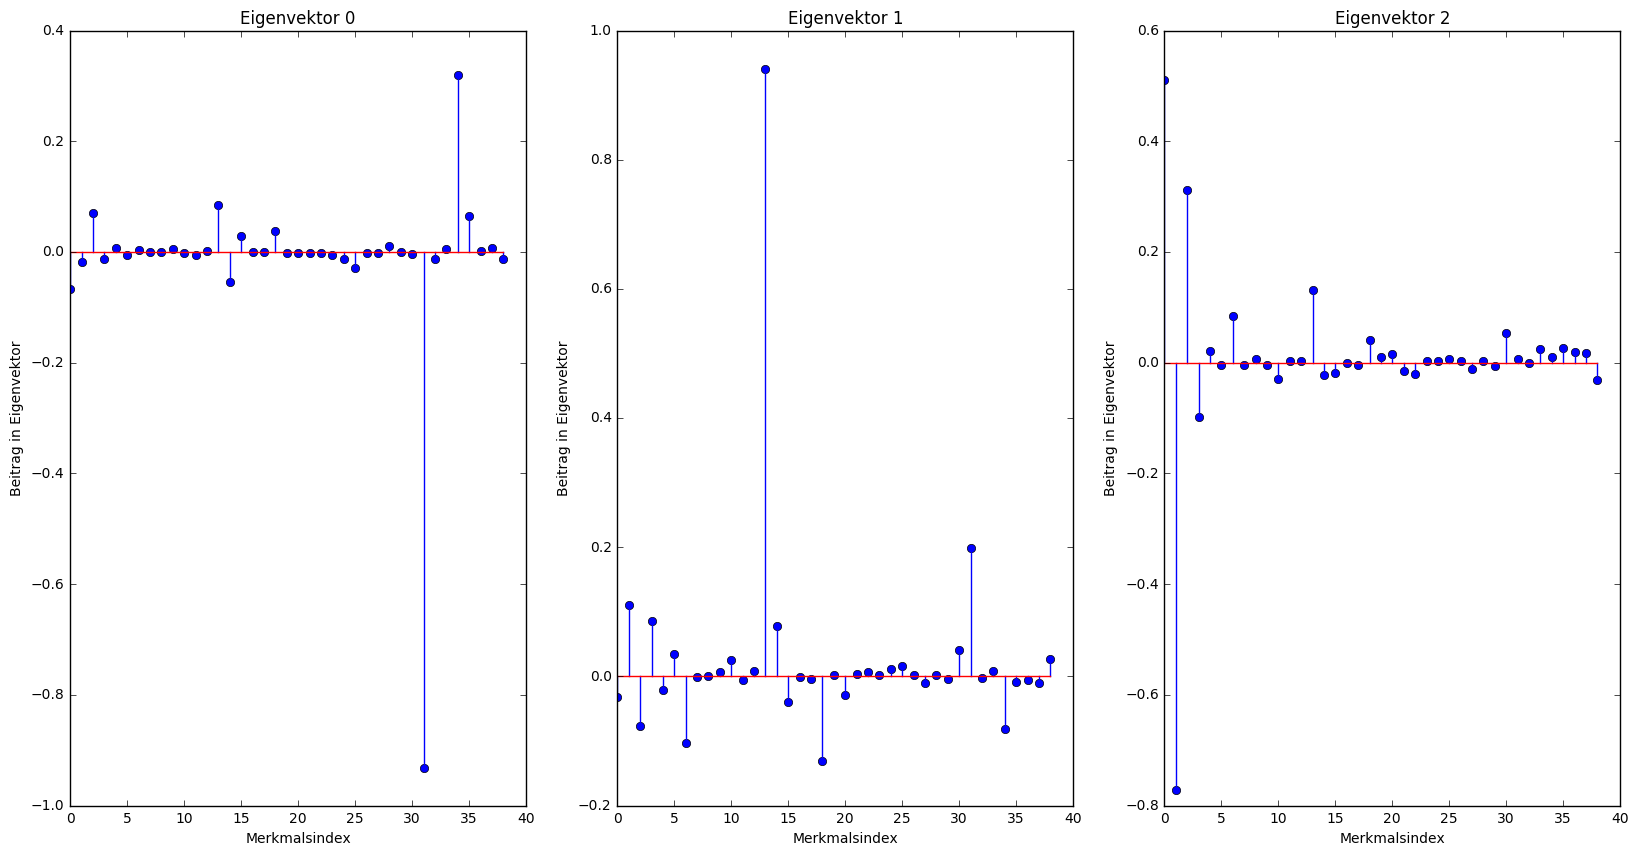

In [20]:
plt.figure(figsize=(20,10))

for index in range(3):
    ax = plt.subplot(1,3,index+1)
    ax.stem(eigvecs[:, index])
    ax.set_title('Eigenvektor {}'.format(index))
    ax.set_xlabel('Merkmalsindex')
    ax.set_ylabel('Beitrag in Eigenvektor')